# SNR tuto

This is a companion notebook for the tutorial on computing the SNR vale for a set of traces, and using the SNR to predict the number of traces required for a successfull DPA attack. We are in the known key model and we will be calculating the SNR for a couple of leakage models: LSB, LS2B, MSB, HW and ID.  

For our traces, we have cloned the TinyAES implementation from this repository https://github.com/kokke/tiny-AES-c/ and we loaded the firmware on an ARM Cortex M0, which was modified for the collection of traces. The set of traces we collected are available to you https://zenodo.org/record/4742566#.YJVN4mYzZqs. Special thanks to Alexandre Ioos for collecting the traces. 

In [1]:
import scipy.io
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm #progress bar for visualization of progress

After loading the relevant libraries, lets have a look at the datafiles. We have the following files:
- `overview_trace.npy`, the trace is measured while the board is performing a full AES encryption. 
- `trace_set_10k.npy` , is the trace set file, with a given `number_of_traces`, captured from the oscilloscope. 
It captures roughly the first round of execution (it contains samples $10000-25000$ from the overview trace). Each trace has `number_of_samples` samples. 
- `plaintex.txt`, contains the plaintexts which are encrypted by the algorithm. One plaintext corresponds to one trace (they are provided in order).

Let's load these datafiles and figure out how many traces we have in the trace set file and how many samples each trace has. 


In [2]:
overview_trace = np.load("overview_trace.npy")

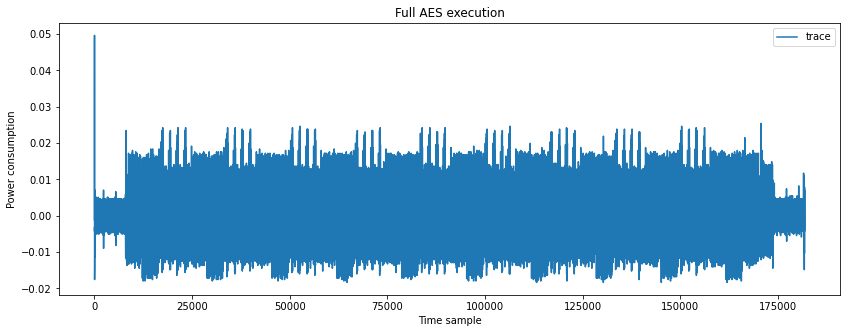

In [3]:
plt.figure(figsize=(14,5))
plt.plot(overview_trace, label='trace')
plt.title('Full AES execution')
plt.xlabel('Time sample')
plt.ylabel('Power consumption')
plt.legend()
plt.show()


In the figure above we can clearly idnetify the 10 rounds of the 10 AES. The execution is surrounded by the execution of 500 NOP instruction (before and after the algorithm). There are no countermeasures added to this implementation.

In [4]:
traces = np.load("trace_set_10k.npy")

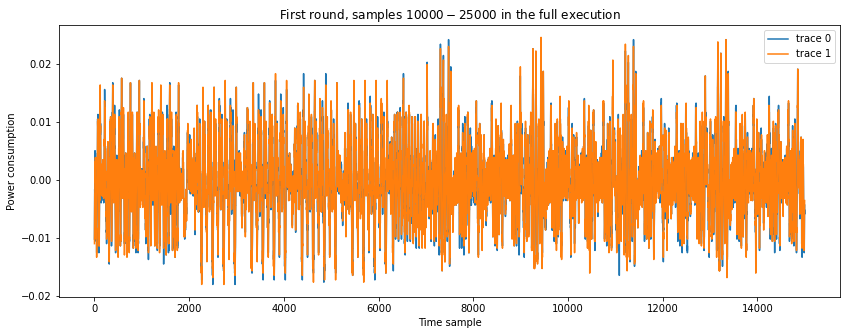

In [5]:
plt.figure(figsize=(14,5))
plt.plot(traces[0,:], label='trace 0')
plt.plot(traces[1,:], label='trace 1')
plt.title('First round, samples $10000-25000$ in the full execution')
plt.xlabel('Time sample')
plt.ylabel('Power consumption')
plt.legend()
plt.show()


In [6]:
number_of_traces=len(traces)
print('Number of traces:', number_of_traces)
number_of_samples=len(traces[0])
print('Number of samples:', number_of_samples)

Number of traces: 10000
Number of samples: 15000


It also seems that the traces are pretty well aligned, so smooth sailing. We are provided with the AES S-box table, which we will use during the attack. To refresh your memory on the use of the S-box, please refer to this article https://en.wikipedia.org/wiki/Rijndael_S-box. 

In [7]:
sbox = [0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67,
            0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59,
            0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7,
            0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1,
            0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05,
            0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83,
            0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29,
            0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
            0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa,
            0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c,
            0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc,
            0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec,
            0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19,
            0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee,
            0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49,
            0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
            0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4,
            0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6,
            0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70,
            0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9,
            0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e,
            0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1,
            0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0,
            0x54, 0xbb, 0x16]

Read the plaintext file, we need this to compute the LSB leakage model. 

In [8]:
plaintext = np.zeros(shape=(number_of_traces, 16))

filename="plaintext_new.txt"
with open(filename) as f:
    content = f.readlines()

content = [x.strip() for x in content] 
plaintext = np.array([bytearray.fromhex(c) for c in content])

#print(plaintext)

Some definitions of variables to help us decypher the code:

- `TARGET_BYTE`, the attack is performed using divide-and-conquer approach, one byte at a time. This variable represents the key byte we are recovering. 
- `BYTE_COMBINATIONS`, is a constant which represents the number of hypothesis, `key_hypothesis`, we make for determining the correct value of `TARGET_BYTE`
-`prediction_matrix`, for each plaintext(=`number_of_traces`), and for each `key_hypothesis` compute the S-box out for `TARGET_BYTE`


In [9]:
def prepare_data(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = the leakage model of the target intermediate value
    
    returns a dictionary of the form
       'label_value': list of traces associated with 'label_value'
    """
   
    labels=np.unique(labels_set)
    #initialize the dictionary
    d={}
    for i in labels:
         d[i]=[]
    for count, label in enumerate(labels_set):
        d[label].append(trace_set[count])
    return d

def return_snr_trace(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = a set of labels of the same lenght as trace_set
    
    returns a dictionary of the form
       'label_value': mean_sample trace with 'label_value'
    """
    mean_trace={}
    signal_trace=[]
    noise_trace=[]
    labels=np.unique(labels_set) #determine the set of unique values for the leakage model
    #for LSB and MSB, labels ={0,1} and for HW, labels={0,1,2,3,4,5,6,7}
    grouped_traces=prepare_data(trace_set, labels_set) # we group the traces according to the label
    #compute the mean trace (the same are the signal traces)   
    for i in labels:
        mean_trace[i]=np.mean(grouped_traces[i], axis=0)
        signal_trace.append(mean_trace[i]) 
    #compute the noise trace  
    for i in labels:
        for trace in grouped_traces[i]:
            noise_trace.append(trace-mean_trace[i])
    var_noise=np.var(noise_trace, axis=0)
    var_signal=np.var(signal_trace, axis=0)
    snr_trace=var_signal/var_noise  
    return snr_trace   


## Lets pick our target

The correct key for this encryption is: 0xCAFEBABEDEADBEEFCAFEBABEDEADBEAF

In [10]:
TARGET_BYTE=0
CORRECT_BYTE_VALUE=0xCA

## SNR for the LSB

In [11]:
label_LSB=[] #the label to divide the data
for i in tqdm(range(0, number_of_traces)):
    label_LSB.append(sbox[CORRECT_BYTE_VALUE ^ int(plaintext[i][TARGET_BYTE])]&0b1)
snr_trace_LSB=return_snr_trace(traces, label_LSB)


100%|██████████| 10000/10000 [00:00<00:00, 1137530.92it/s]


In [12]:

# plt.figure(figsize=(14,5))
# plt.plot(grouped_traces_LSB[0])
# plt.title("SNR trace for LSB leakage model")
# plt.xlabel('Time sample')
# plt.ylabel('SNR value')
# plt.show()

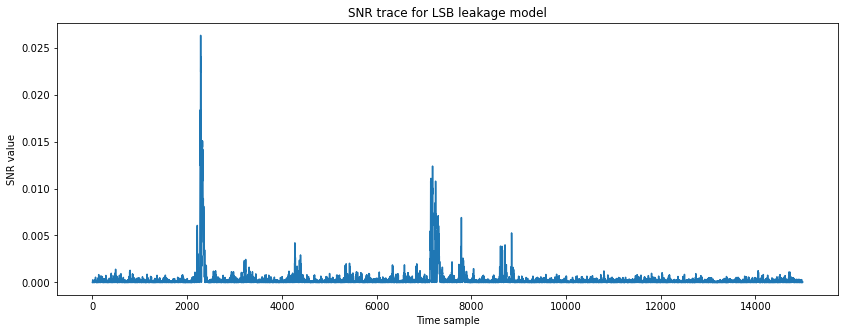

In [13]:
plt.figure(figsize=(14,5))
plt.plot(snr_trace_LSB)
plt.title("SNR trace for LSB leakage model")
plt.xlabel('Time sample')
plt.ylabel('SNR value')
plt.savefig("SNR_LSB.png")
#plt.show()

## SNR for LS2B

In [14]:
label_LS2B=[] #the label to divide the data
for i in tqdm(range(0, number_of_traces)):
    label_LS2B.append(sbox[CORRECT_BYTE_VALUE ^ int(plaintext[i][TARGET_BYTE])]&0b11)
snr_trace_LS2B=return_snr_trace(traces, label_LS2B)

100%|██████████| 10000/10000 [00:00<00:00, 997290.34it/s]


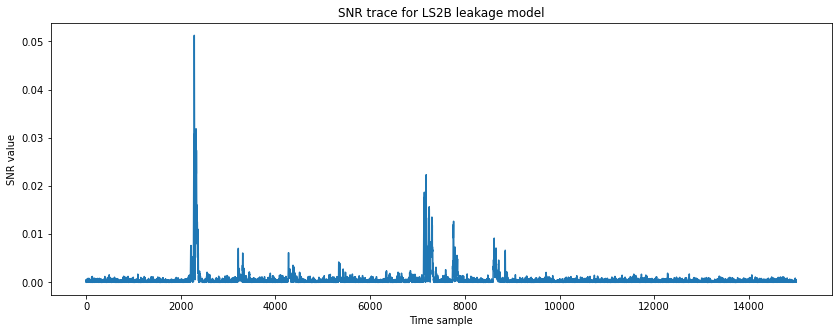

In [15]:
plt.figure(figsize=(14,5))
plt.plot(snr_trace_LS2B)
plt.title("SNR trace for LS2B leakage model")
plt.xlabel('Time sample')
plt.ylabel('SNR value')
plt.savefig("SNR_LS2B.png")
#plt.show()

## SNR for MSB

In [16]:
label_MSB=[] #the label to divide the data
for i in tqdm(range(0, number_of_traces)):
    label_MSB.append(sbox[CORRECT_BYTE_VALUE ^ int(plaintext[i][TARGET_BYTE])]&0b10000000)

snr_trace_MSB=return_snr_trace(traces, label_MSB)


100%|██████████| 10000/10000 [00:00<00:00, 864448.47it/s]


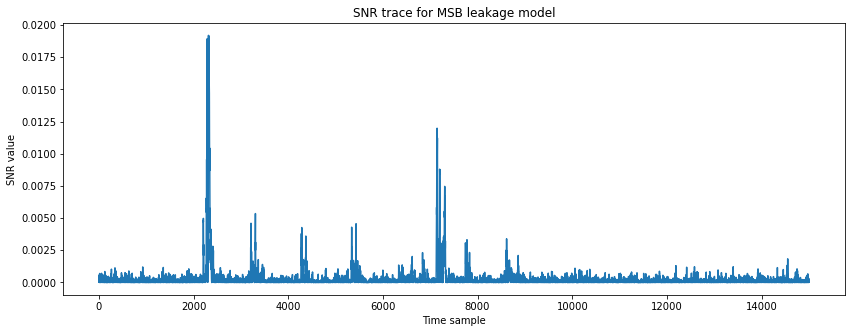

In [17]:
plt.figure(figsize=(14,5))
plt.plot(snr_trace_MSB)
plt.title("SNR trace for MSB leakage model")
plt.xlabel('Time sample')
plt.ylabel('SNR value')
plt.show()

## SNR for HW leakage model


In [18]:
def HW(x):
    return sum([x&(1<<i)>0 for i in range(32)])
label_HW=[] #the label to divide the data
for i in tqdm(range(0, number_of_traces)):
    label_HW.append(HW(sbox[CORRECT_BYTE_VALUE ^ int(plaintext[i][TARGET_BYTE])]))
snr_trace_HW=return_snr_trace(traces, label_HW)


100%|██████████| 10000/10000 [00:00<00:00, 189549.07it/s]


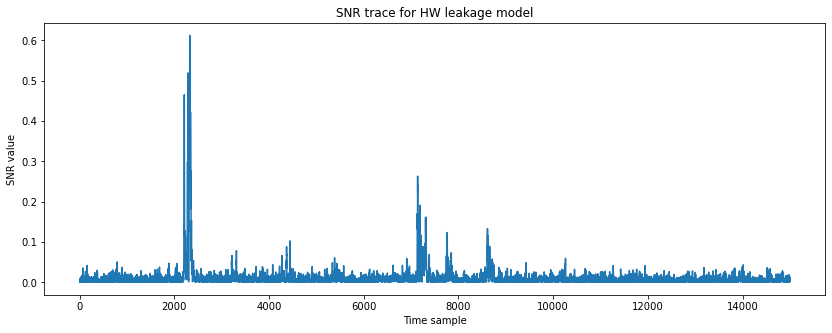

In [19]:
plt.figure(figsize=(14,5))
plt.plot(snr_trace_HW)
plt.title("SNR trace for HW leakage model")
plt.xlabel('Time sample')
plt.ylabel('SNR value')
plt.show()

In [23]:
label_ID=[] #the label to divide the data
for i in tqdm(range(0, number_of_traces)):
    label_ID.append(sbox[CORRECT_BYTE_VALUE ^ int(plaintext[i][TARGET_BYTE])])
snr_trace_ID=return_snr_trace(traces, label_ID)

100%|██████████| 10000/10000 [00:00<00:00, 697829.47it/s]


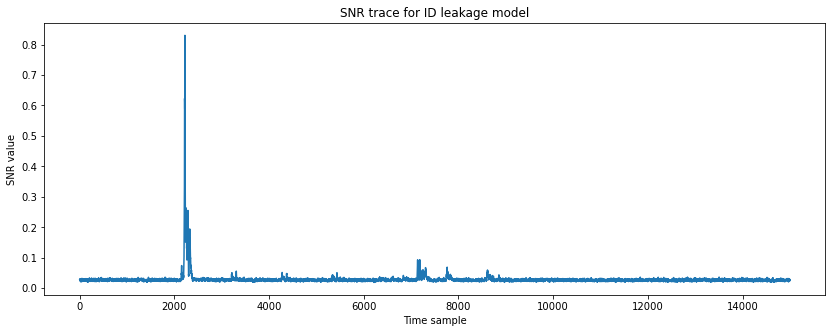

In [24]:
plt.figure(figsize=(14,5))
plt.plot(snr_trace_ID)
plt.title("SNR trace for ID leakage model")
plt.xlabel('Time sample')
plt.ylabel('SNR value')
plt.show()

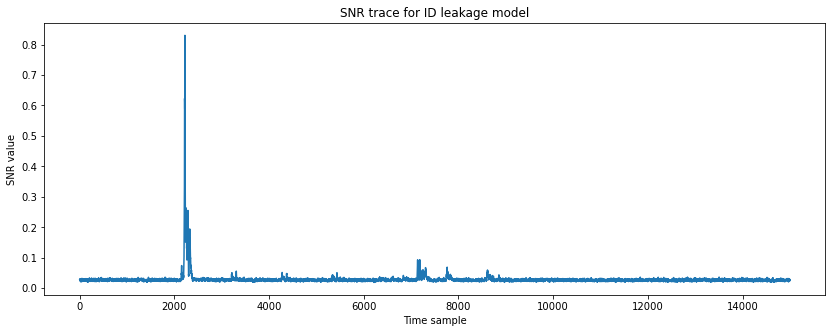

In [25]:
plt.figure(figsize=(14,5))
plt.plot(snr_trace_ID)
plt.title("SNR trace for ID leakage model")
plt.xlabel('Time sample')
plt.ylabel('SNR value')
plt.show()